In [ ]:
!pip3 install tf-models-official

In [ ]:
!pip3 install tensorflow_text

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

import tensorflow_text as text
import tensorflow_hub as hub

from official.modeling import tf_utils
from official import nlp
from official.nlp import bert

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# input folders
data = "/content/drive/My Drive/295R-Caps-Pattern/Data"

In [6]:
# Loading the review texts
review_df = pd.read_pickle(f'{data}/clean/month_level_review.pickle')
review_df = review_df[['asin', 'year_month', 'review_text', 'reviewvotes_num']]

In [7]:
# Loading the rank data
bsr_df = pd.read_json(f'{data}/clean/month_level_rank.csv')
bsr_df = bsr_df[['asin', 'year_month', 'mean_month_rank', 'median_month_rank', 'rolling_median_month_rank']]

In [8]:
# processing rank df for the merge
bsr_df['year_month'] = pd.to_datetime(bsr_df['year_month'])
bsr_df = bsr_df.sort_values(['asin', 'year_month'])
bsr_df['target_rank'] = bsr_df.groupby(['asin'])["median_month_rank"].shift(-1)

# processing review df for the merge
review_df['year_month'] = pd.to_datetime(review_df['year_month'])

In [9]:
# merging the data sets
products_df = pd.merge(review_df, bsr_df, on=["asin", "year_month"])
products_df = products_df.dropna()

In [10]:
# creating the target variable
products_df['rank_change'] = (products_df['target_rank'] - products_df['median_month_rank'])/products_df['median_month_rank']
products_df['normalised_rank_change'] = (products_df['rank_change'] - products_df['rank_change'].min())/(products_df['rank_change'].max() - products_df['rank_change'].min());

In [11]:
def process_moving_median_months(row):
  """Processes the moving median column to make sure it
  doesn't break our model"""
  rolling_median = np.array(row['rolling_median_month_rank'])
  # impute the NaNs
  try: rolling_median[np.isnan(rolling_median)] = np.nanmean(rolling_median)
  except: return np.ones(30)*0.24191888901999709
  # make sure all are of length 30 (prioritising the last 30 values)
  if len(rolling_median) < 30:
    impute_value = np.nanmean(rolling_median)
    rolling_median = np.append(np.array([impute_value]*(30-len(rolling_median))), rolling_median)
  else:
    rolling_median = rolling_median[-30:]
  return rolling_median

products_df['rolling_median_month_rank'] = products_df.apply(process_moving_median_months, axis=1)

In [ ]:
def create_num_reviews(row):
  try: return len(row["review_text"])
  except: return 0

products_df["num_reviews"] = products_df.apply(create_num_reviews, axis=1)

In [ ]:
# example filtering (used during the train generator)
products_df[(products_df['asin']==products_df.iloc[1]['asin']) & (products_df['year_month']<=products_df.iloc[1]['year_month'])];

In [ ]:
products_df.head()

,asin,year_month,review_text,reviewvotes_num,mean_month_rank,median_month_rank,rolling_median_month_rank,target_rank,rank_change,normalised_rank_change
0,B000052XB5,2018-01-01,[Honestly love this because I can eat ice crea...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5]",0.097395,0.097395,"[0.0431385783, 0.0420857428, 0.0420857428, 0.0...",0.120613,0.023217,0.511609
1,B000052XB5,2019-01-01,[You might still have to take 3 tabs together ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0.085390,0.085390,"[0.0402410374, 0.039752259000000005, 0.0384139...",0.070835,-0.014555,0.492722
2,B000052XB5,2020-01-01,[Me encanto!! Super bien empaquetado y el prod...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]",0.045969,0.045969,"[0.0251247952, 0.0244153516, 0.0244153516, 0.0...",0.061649,0.015680,0.507840
3,B000052XB5,2021-01-01,[easy to swallow and acts fast to counteract l...,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.023476,0.023476,"[0.0045402867, 0.0046973071, 0.005080543500000...",0.007223,-0.016253,0.491874
4,B000052XB5,2018-02-01,"[Not as fast acting as I thought it would be.,...","[0, 0, 0, 3, 1, 0, 0, 0, 1, 0, 0, 1, 0, 5, 1, 0]",0.120613,0.120613,"[0.05059336710714286, 0.05059336710714286, 0.0...",0.088528,-0.032085,0.483957


In [ ]:
# Freeing up RAM
del bsr_df
del review_df

In [ ]:
# changing data to series
products_dict = products_df.to_dict('series')
for key in products_dict.keys():
  products_dict[key] = list(products_dict[key])

products_dict['review_text'] = [list(map(str, reviews_text_list)) for reviews_text_list in products_dict['review_text']]

In [ ]:
# Model Parameters
MAX_SEQ_LENGTH = 128
LATENT_LAYER_SIZE = 400
READING_IN_CHUNKS = 100
TRAIN_PROPORTION = 1  # change later
TRAIN_EPOCHS = 2
ACTIVATION_ALPHA = 0.04
DROPOUT_RATE = 0.1
EPOCH_STEPS = 100

In [ ]:
# resizing data based on TRAIN_PROPORTION
for key in products_dict.keys():
  products_dict[key] = products_dict[key][:int(len(products_dict[key])*TRAIN_PROPORTION)]

In [ ]:
def review_text_generator(review_dict=products_dict, 
                          number_of_chunks=READING_IN_CHUNKS):
    """function (generator) to read review text piece by piece."""
    chunk_size = len(review_dict['asin'])//number_of_chunks
    chunk_number = 0
    while True:
        if chunk_number+chunk_size >= len(review_dict['asin']):
            asin = review_dict['asin'][chunk_number:]
            month = review_dict['year_month'][chunk_number:]
            rank_feature = review_dict['rolling_median_month_rank'][chunk_number:]
            bsr_target = review_dict['normalised_rank_change'][chunk_number:]
            yield asin, month, rank_feature, bsr_target
            break
        asin = review_dict['asin'][chunk_number:chunk_number+chunk_size]
        month = review_dict['year_month'][chunk_number:chunk_number+chunk_size]
        rank_feature = review_dict['rolling_median_month_rank'][chunk_number:chunk_number+chunk_size]
        bsr_target = review_dict['normalised_rank_change'][chunk_number:chunk_number+chunk_size]
        chunk_number += chunk_size
        yield asin, month, rank_feature, bsr_target

In [ ]:
def train_generator(text_generator, review_dict=products_dict, products_df=products_df,
                   number_of_chunks=READING_IN_CHUNKS, uncased=False):
    """function (generator) to create cumulative data one by one."""
    # Note: This generator will keep repeating, so stop condition must be in
    # the iterator or fit method
    while True: 
      for asins, months, rank_feature, bsrs in text_generator(review_dict,
                                                              number_of_chunks):
          for i in range(len(asins)):
            # create cumulative data
            if len(rank_feature[i]) != 30: continue
            filtered_data = products_df[(products_df['asin']==asins[i]) & 
                                        (products_df['year_month']<=months[i])]
            text = np.concatenate(list(filtered_data['review_text']))
            if uncased: text = np.array([review_text.lower() for review_text in text])
            vote = np.concatenate(list(filtered_data['reviewvotes_num'])) + 1
            if not len(text)==len(vote) or np.all(vote==0): continue
            rank_feats = np.vstack((np.array([rank_feature[i]]), np.zeros((len(text)-1, 30))))
            bsr = np.array([[bsrs[i]]])
            yield [text, vote, rank_feats], bsr

In [ ]:
# confirming that the generator works as expected
for [text, vote, rank_feats], bsr in train_generator(review_text_generator, uncased=True):
  print("Text:", text)
  print("Votes:", vote)
  print("Moving median rank:", rank_feats)
  print("BSR:", bsr)
  break

In [ ]:
def create_bert(max_seq_length=MAX_SEQ_LENGTH):
  """Returns BERT encodings."""
  # takes in text of the form np.array(["first review.", ...])
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string)
  # creates BERT tokens for the text
  preprocessor = hub.KerasLayer(
      "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
  encoder_inputs = preprocessor(text_input)
  # encodes the input tokens
  encoder = hub.KerasLayer(
      "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4",
      trainable=False)
  # retrieves the vector representation of all the reviews seperately
  encodings = encoder(encoder_inputs)["pooled_output"]
  # creating final model
  model = tf.keras.models.Model(inputs=text_input, outputs=encodings,
                                name="BERT_uncased")
  return model

In [ ]:
def create_model(transformer, latent_size=LATENT_LAYER_SIZE,
                 max_seq_length=MAX_SEQ_LENGTH,
                 activation_alpha=ACTIVATION_ALPHA,
                 dropout_rate=DROPOUT_RATE):
  """Returns model structure for regression on transformer embeddings."""
  # Input text of the form: np.array(["first review.", ...])
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string,
                                     name="text_input")
  # input votes of the form: np.array([44, 40, ...])
  votes_input = tf.keras.layers.Input(shape=(), dtype=tf.float32,
                                      name="votes_input")
  # previous month bsr timeline
  previous_bsr_input = tf.keras.layers.Input(shape=(30,), dtype=tf.float32,
                                      name="bsr_input")
  # create encodings for the text
  encodings = transformer(text_input)
  # add additional dense layer to interpret transformer encodings and keep
  # shapes constant regardless of transformer shape
  latent_description = tf.keras.layers.Dense(
      latent_size, activation=tf.keras.layers.LeakyReLU(alpha=activation_alpha),
      name="latent_desc")(encodings)
  latent_description = tf.keras.layers.Dropout(dropout_rate)(latent_description)
  # weigh the reshaped transformer representations by the votes 
  weighted_sum = tf.reduce_sum(
    tf.keras.layers.Multiply(name="weighted_vectors")([
        tf.expand_dims(votes_input, 1, name="votes_reshaped"),
        latent_description]),
    0, name="weighted_sum"
  )
  # calculate total votes for all reviews for this product
  total_votes = tf.reduce_sum(votes_input, name="total_votes")
  # mean of the weighted representations
  weighted_mean = tf.transpose(
      tf.expand_dims(
          weighted_sum/total_votes, axis=1,
          name="weights_reshaped"
      ), name="weighted_mean"
  )
  # final aggregated review representation
  agg_review_representation = tf.keras.layers.Dense(
      latent_size, activation=tf.keras.layers.LeakyReLU(alpha=activation_alpha),
      name="agg_review_repr")(weighted_mean)
  agg_review_representation = tf.keras.layers.Dropout(dropout_rate)(agg_review_representation)
  # making shapes of votes and bsr_input compatible
  total_votes_reshaped = tf.expand_dims(
      tf.expand_dims(total_votes, 0, name="total_votes_reshaped_1"),
      1, name="total_votes_reshaped_2"
  )
  previous_bsr_input_reshaped = previous_bsr_input[0:1,:]
  # concatenate all three inputs
  combined_text_meta = tf.keras.layers.concatenate(
    [agg_review_representation, total_votes_reshaped, previous_bsr_input_reshaped],
    axis=1, name="concat_all_inputs"
  )
  # one more dense layer to account for interplay between inputs
  final_vector = tf.keras.layers.Dense(
      latent_size, activation=tf.keras.layers.LeakyReLU(alpha=activation_alpha),
      name="final_vector")(combined_text_meta)
  final_vector = tf.keras.layers.Dropout(dropout_rate)(final_vector)
  # final dense unit for the regression
  final = tf.keras.layers.Dense(
      1, activation="sigmoid",
      name="final_answer")(final_vector)
  # final model description
  model = tf.keras.models.Model(
      inputs=[text_input, votes_input, previous_bsr_input],
      outputs=final, name="transformer_regression")
  return model

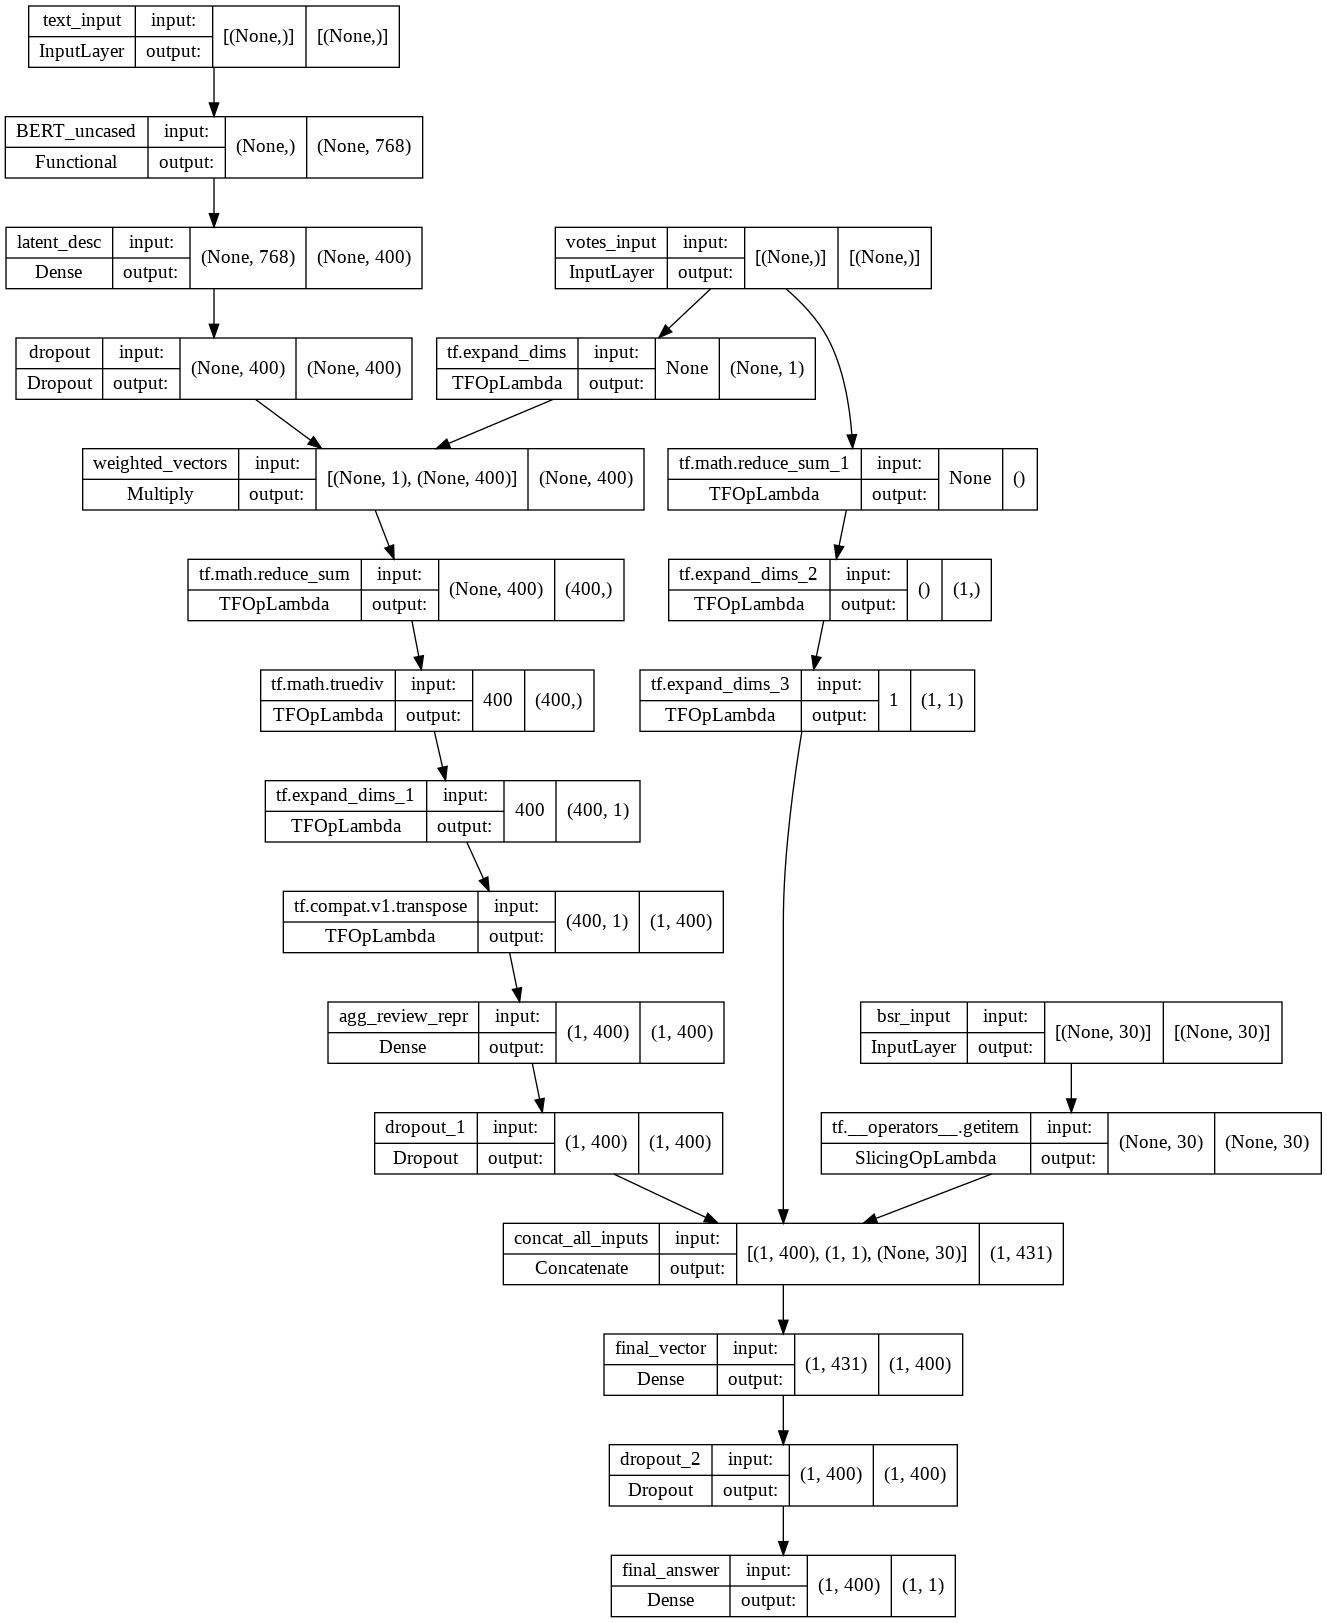

In [ ]:
bert_model = create_bert()
model = create_model(bert_model)
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.MeanSquaredError(name="mean_squared_error"),
    metrics=[tf.keras.metrics.mean_absolute_error]
)

In [ ]:
# Prediction on first row before training (random weights)
for x, y in train_generator(review_text_generator, uncased=True):
  print(f"Model prediction: {model.predict(x)[0][0]}, Truth value: {y[0][0]}")
  break

Model prediction: 2.1264601191006705e-09, Truth value: 0.511608737


In [ ]:
training_history = model.fit(
    train_generator(
        review_text_generator,
        uncased=True), 
    epochs=TRAIN_EPOCHS,
    steps_per_epoch=EPOCH_STEPS)

Epoch 1/2
100/100 [==============================] - 1062s 10s/step - loss: 0.2624 - mean_absolute_error: 0.5029
Epoch 2/2
100/100 [==============================] - 410s 4s/step - loss: 0.0504 - mean_absolute_error: 0.1022


In [ ]:
# Prediction on first row after training
for i, (x, y) in enumerate(train_generator(review_text_generator, uncased=True)):
  print(f"{i}  Model prediction: {model.predict(x)[0][0]}, Truth value: {y[0][0]}")
  break

0  Model prediction: 0.4855823278427124, Truth value: 0.511608737


In [ ]:
print(f"Mean of target: {np.mean(products_dict['normalised_rank_change'])}. Std. Dev.: {np.std(products_dict['normalised_rank_change'])}")